In [2]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

import PyLasMech as plm

### Read well log datas

In [4]:
LogFiles=plm.FileFinder("../Data/Petrophysics")

[IO] Found 9 log files


,FileName,Location
0,15_9-F-11B_INPUT.LAS,..\Data\Petrophysics\15_9-F-11B\15_9-F-11B_INP...
1,15_9-F-12_INPUT.LAS,..\Data\Petrophysics\15_9-F-12\15_9-F-12_INPUT...
2,15_9-F-14_INPUT.las,..\Data\Petrophysics\15_9-F-14\15_9-F-14_INPUT...
3,15_9-F-15C_INPUT.las,..\Data\Petrophysics\15_9-F-15C\15_9-F-15C_INP...
4,15_9-F-15D_INPUT.LAS,..\Data\Petrophysics\15_9-F-15D\15_9-F-15D_INP...
5,15_9-F-1B_INPUT.LAS,..\Data\Petrophysics\15_9-F-1B\15_9-F-1B_INPUT...
6,15_9-F-1C_INPUT.LAS,..\Data\Petrophysics\15_9-F-1C\15_9-F-1C_INPUT...
7,15_9-F-4_INPUT.las,..\Data\Petrophysics\15_9-F-4\15_9-F-4_INPUT.las
8,15_9-F-5_INPUT.las,..\Data\Petrophysics\15_9-F-5\15_9-F-5_INPUT.las


In [3]:
WellLog=plm.ReadLas(LogFiles[5])
#Print las file summary table
plm.printLas(WellLog)

[IO] Reading F:\Course\PETE 4241\Projects\Data\WellLog\15_9-F-1B\15_9-F-1B_INPUT.LAS.....
[Warnning] No intersection! Get union!
Done!
[LAS Info]
Well Name= 15/9-F-1 B
Start/Step/End Depth=(145.900000:0.100000:3464.900000)
NULL value= -999.25
Common Depth= (145.9, 3464.9)


,Curves,Available Depth (Non-NULL),Raw Min/Max Val,Unit,Comments
0,DEPTH,"[145.9, 3464.9]","[145.9, 3464.9]",M,0 Depth
1,ABDCQF01,"[3120.0, 3442.5]","[2.1046, 3.0577]",g/cm3,1 ABDCQF01:COMPOSITE:rC:NONE:v1
2,ABDCQF02,"[3120.0, 3442.5]","[2.1182, 3.0521]",g/cm3,2 ABDCQF02:COMPOSITE:rC:NONE:v1
3,ABDCQF03,"[3120.0, 3442.5]","[2.0902, 3.0505]",g/cm3,3 ABDCQF03:COMPOSITE:rC:NONE:v1
4,ABDCQF04,"[3120.0, 3442.5]","[2.1247, 3.0866]",g/cm3,4 ABDCQF04:COMPOSITE:rC:NONE:v1
5,BS,"[145.9, 3464.9]","[8.5, 36.0]",inches,5 BS:COMPOSITE:rC:NONE:v1
6,CALI,"[3090.0, 3441.8]","[8.3604, 10.1917]",inches,6 CALI:COMPOSITE:rC:NONE:v1
7,DRHO,"[3090.0, 3442.5]","[-0.0225, 0.2206]",g/cm3,7 DRHO:COMPOSITE:rC:NONE:v1
8,DT,"[2998.5, 3424.6]","[54.9283, 125.9827]",us/ft,8 DT:COMPOSITE:rC:NONE:v1
9,DTS,"[2999.0, 3424.7]","[99.9092, 202.14]",us/ft,9 DTS:COMPOSITE:rC:NONE:v1


### Geomechanical properties calculation

> ##### Parameter and unit setup

In [4]:
#Unit Converter
ft=0.3048 #m
g_cm3=1000 #kg/m3
g=9.8 #m/s2
meter=1
mega=1e6 #Mega
Pa=1 #Pa
us=0.000001 #us, micro seconds
psi=6894.76

#Basic paramters for Volve field
rho_w=1.0*g_cm3  #formation fluid density
rho_m=2.65*g_cm3 #rock matrix density
z_w=80*meter # ocean water depth @ https://www.offshore-technology.com/projects/volve-oil-field-north-sea/
RHOB_avg=1.75*g_cm3 # average bulk density above the reservoir, Z<2576 ft
phi0=0.37
beta=0.0266*(1/mega*Pa) #convert it unit back to Pa


#RHOB DT DTS etc from Log
l=WellLog
param=l.plm_param
GeoMechParams={}


#RHOB DT DTS etc from Log
NonNanIndex=param.getCommonNonNanIndex(l,["RHOB","DT","DTS"])

DZ=l[0][NonNanIndex]
#Auto unit setup
if(param.Units[0]=="F" or param.Units[0]=="f"): DZ=DZ*ft
elif(param.Units[0]=="M" or param.Units[0]=="m"): DZ=DZ*meter
else:print("!!!Unknown Unit!!!!")
    
if("RHOB" in param.CurveNames): 
    RHOB=l["RHOB"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("RHOB")]
    if(unit=="g/cm3"): RHOB=RHOB*g_cm3
    else:print("!!!Unknown Unit!!!!",unit)    
if("DT" in param.CurveNames): 
    DT=l["DT"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("DT")]
    if(unit=="us/ft"): DT=DT*us/ft
    else:print("!!!Unknown Unit!!!!",unit)  
if("DTS" in param.CurveNames): 
    DTS=l["DTS"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("DTS")]
    if(unit=="us/ft"): DTS=DTS*us/ft
    else:print("!!!Unknown Unit!!!!",unit)   

> ##### Vertical stress & its gradient
$$
S_v=\rho _wgz_w+\bar{\rho}_bg\left( z_0-z_w \right) +\int_{z_0-z_w}^z{\rho _b\left( z \right) gdz}
$$

In [5]:
z_0=DZ[0]

#1. Overburden stress
Sv0=rho_w*g*z_w+RHOB_avg*g*(z_0-z_w)
Sv=[Sv0]+list(Sv0+integrate.cumtrapz(RHOB*g, DZ))
GeoMechParams["Sv"]=np.array(Sv)
GeoMechParams["Sv_grad"]=GeoMechParams["Sv"]/DZ

plm.showTable([DZ/1e3,GeoMechParams["Sv"]/1e6],['Depth_GOM(km)','Sv(MPa)'],preview=10)

+----+-----------------+-----------+
|    |   Depth_GOM(km) |   Sv(MPa) |
|----+-----------------+-----------|
|  0 |          3.0985 |   52.5513 |
|  1 |          3.1312 |   53.3736 |
|  2 |          3.1639 |   54.1826 |
|  3 |          3.1966 |   54.9181 |
|  4 |          3.2293 |   55.7066 |
|  5 |          3.262  |   56.4962 |
|  6 |          3.2947 |   57.2328 |
|  7 |          3.3274 |   58.0384 |
|  8 |          3.3601 |   58.8309 |
|  9 |          3.3928 |   59.6208 |
+----+-----------------+-----------+


> ##### Hydrostatic pressure in MPa.  
The pore pressure can be calculated as follows:  
$${{P}_{p}}={{\bar{\rho }}_{w}}g{z} $$

In [6]:
GeoMechParams["P_pore"]=rho_w*g*DZ

plm.showTable([DZ/1e3,GeoMechParams["P_pore"]/1e6],['Depth_GOM(km)','PorePressure(MPa)'],preview=10)

+----+-----------------+---------------------+
|    |   Depth_GOM(km) |   PorePressure(MPa) |
|----+-----------------+---------------------|
|  0 |          3.0985 |             30.3653 |
|  1 |          3.1312 |             30.6858 |
|  2 |          3.1639 |             31.0062 |
|  3 |          3.1966 |             31.3267 |
|  4 |          3.2293 |             31.6471 |
|  5 |          3.262  |             31.9676 |
|  6 |          3.2947 |             32.2881 |
|  7 |          3.3274 |             32.6085 |
|  8 |          3.3601 |             32.929  |
|  9 |          3.3928 |             33.2494 |
+----+-----------------+---------------------+


> ##### Rock porosity
The rock porosity can be calculated using density log as follows:  
$$
\phi =\frac{\rho _m-\rho _b}{\rho _m-\rho _w}
$$

In [7]:
GeoMechParams["PORO"]=(rho_m-RHOB)/(rho_m-rho_w)

plm.showTable([DZ/1e3,GeoMechParams["PORO"]],['Depth_GOM(km)','Porosity'],preview=10)

+----+-----------------+------------+
|    |   Depth_GOM(km) |   Porosity |
|----+-----------------+------------|
|  0 |          3.0985 |  0.0667273 |
|  1 |          3.1312 |  0.0648485 |
|  2 |          3.1639 |  0.064     |
|  3 |          3.1966 |  0.222424  |
|  4 |          3.2293 |  0.0869697 |
|  5 |          3.262  |  0.226061  |
|  6 |          3.2947 |  0.171636  |
|  7 |          3.3274 |  0.197394  |
|  8 |          3.3601 |  0.0693939 |
|  9 |          3.3928 |  0.114848  |
+----+-----------------+------------+


> ##### Porosity by Athy's equation  
The effective vertical stress $\sigma'_v$ can be calculated as follows:
$$\sigma'_v=\sigma_v - p_p $$
The porosity can be calculated as follows:
$$\phi=\phi_0 e^{-\beta \sigma'_v} $$

In [8]:
Sv_eff=GeoMechParams["Sv"]-GeoMechParams["P_pore"]
plm.showTable([DZ/1e3,Sv_eff/1e6],['Depth_GOM(km)','Effective Sv(MPa)'],preview=10)

GeoMechParams["PORO_Athy"]=phi0*np.exp(-beta*Sv_eff)
plm.showTable([DZ/1e3,GeoMechParams["PORO_Athy"]],['Depth_GOM(km)','Porosity_Athy'],preview=10)

+----+-----------------+---------------------+
|    |   Depth_GOM(km) |   Effective Sv(MPa) |
|----+-----------------+---------------------|
|  0 |          3.0985 |             22.186  |
|  1 |          3.1312 |             22.6879 |
|  2 |          3.1639 |             23.1764 |
|  3 |          3.1966 |             23.5914 |
|  4 |          3.2293 |             24.0595 |
|  5 |          3.262  |             24.5286 |
|  6 |          3.2947 |             24.9448 |
|  7 |          3.3274 |             25.4299 |
|  8 |          3.3601 |             25.9019 |
|  9 |          3.3928 |             26.3714 |
+----+-----------------+---------------------+
+----+-----------------+-----------------+
|    |   Depth_GOM(km) |   Porosity_Athy |
|----+-----------------+-----------------|
|  0 |          3.0985 |        0.205071 |
|  1 |          3.1312 |        0.202351 |
|  2 |          3.1639 |        0.199739 |
|  3 |          3.1966 |        0.197546 |
|  4 |          3.2293 |        0.195102 

> ##### Pore pressure by Athy's equation
The Pore pressure by Athy's can be calculated as follows:  
$$ p_p = \sigma_v +\frac{1}{\beta}\ln{\frac{\phi}{\phi_0}} $$

In [10]:
GeoMechParams["P_pore_Athy"]=GeoMechParams["Sv"]+1/beta*np.log(GeoMechParams["PORO"]/phi0)

plm.showTable([DZ/1e3,GeoMechParams["P_pore_Athy"]/1e6],['Depth_GOM(km)','PorePressure_Athy(MPa)'],preview=10)

+----+-----------------+--------------------------+
|    |   Depth_GOM(km) |   PorePressure_Athy(MPa) |
|----+-----------------+--------------------------|
|  0 |          3.0985 |                -11.8431  |
|  1 |          3.1312 |                -12.0944  |
|  2 |          3.1639 |                -11.7805  |
|  3 |          3.1966 |                 35.7859  |
|  4 |          3.2293 |                  1.27265 |
|  5 |          3.262  |                 37.9736  |
|  6 |          3.2947 |                 28.3559  |
|  7 |          3.3274 |                 34.418   |
|  8 |          3.3601 |                 -4.0903  |
|  9 |          3.3928 |                 15.64    |
+----+-----------------+--------------------------+


c:\users\binpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [11]:
plm.appendCurve(l,'Sv', GeoMechParams["Sv"]/1e6, unit='MPa',descr='PyLasMech overburden stress',dataIndex=NonNanIndex)
plm.appendCurve(l,'P_pore', GeoMechParams["P_pore"]/1e6, unit='MPa',descr='PyLasMech pore pressure',dataIndex=NonNanIndex)
plm.appendCurve(l,'PORO', GeoMechParams["PORO"], unit='-',descr='PyLasMech porosity',dataIndex=NonNanIndex)
plm.appendCurve(l,'PORO_Athy', GeoMechParams["PORO_Athy"], unit='-',descr='PyLasMech porosity from Athy',dataIndex=NonNanIndex)
plm.appendCurve(l,'P_pore_Athy', GeoMechParams["P_pore_Athy"]/1e6, unit='MPa',descr='PyLasMech pore pressure from Athy',dataIndex=NonNanIndex)

Input data size(3262) < DEPTH size (33191), NULL value (nan) will be added
[Warnning] No intersection! Get union!
Input data size(3262) < DEPTH size (33191), NULL value (nan) will be added
[Warnning] No intersection! Get union!
Input data size(3262) < DEPTH size (33191), NULL value (nan) will be added
[Warnning] No intersection! Get union!
Input data size(3262) < DEPTH size (33191), NULL value (nan) will be added
[Warnning] No intersection! Get union!
Input data size(3262) < DEPTH size (33191), NULL value (nan) will be added
[Warnning] No intersection! Get union!


> ##### (d) Shear modulus (G,MPa), Possion ratio and Youngs Modulus (E, MPa)
$$
G=\rho_bV_{s}^{2}
\\
\nu =\frac{V_{p}^{2}-2V_{s}^{2}}{2\left( V_{p}^{2}-V_{s}^{2} \right)}
\\
E=2G\left( 1+\nu \right) 
$$

In [12]:
Vp=1/DT
Vs=1/DTS

plm.showTable([DZ/1e3,Vp,Vs],
           ['Depth(km)','$V_p$ (m/s)','$V_s$ (m/s)'])

GeoMechParams["G"]=RHOB*Vs*Vs
GeoMechParams["v"]=(Vp**2-2*Vs**2)/2/(Vp**2-Vs**2)
GeoMechParams["E"]=2*GeoMechParams["G"]*(1+GeoMechParams["v"]) 

plm.showTable([DZ/1e3,GeoMechParams["G"]/1e9,GeoMechParams["v"],GeoMechParams["E"]/1e9],['Depth(km)','G(GPa)','v','E(GPa)'])

+----+-------------+---------------+---------------+
|    |   Depth(km) |   $V_p$ (m/s) |   $V_s$ (m/s) |
|----+-------------+---------------+---------------|
|  0 |      3.0985 |       4580.6  |       2129.41 |
|  1 |      3.1312 |       3808.8  |       1945.41 |
|  2 |      3.1639 |       3555.21 |       1859.97 |
|  3 |      3.1966 |       2507.25 |        nan    |
|  4 |      3.2293 |       3483.93 |        nan    |
|  5 |      3.262  |       3379.79 |       2107.28 |
|  6 |      3.2947 |       3912.72 |       2385.89 |
|  7 |      3.3274 |       3615.44 |       2262.9  |
|  8 |      3.3601 |       4171.12 |       2363.48 |
|  9 |      3.3928 |       4053.82 |       2318.06 |
+----+-------------+---------------+---------------+
+----+-------------+-----------+------------+----------+
|    |   Depth(km) |    G(GPa) |          v |   E(GPa) |
|----+-------------+-----------+------------+----------|
|  0 |      3.0985 |  11.5169  |   0.362155 |  31.3756 |
|  1 |      3.1312 |   9.62432

In [13]:
GeoMechParams["UCS"]=np.exp(-6.36+2.45*np.log10(0.86*Vp-1172))*mega*Pa
plm.showTable([DZ/1e3,GeoMechParams["UCS"]/1e6],['Depth(km)','UCS(MPa)'],preview=10)

+----+-------------+------------+
|    |   Depth(km) |   UCS(MPa) |
|----+-------------+------------|
|  0 |      3.0985 |    7.94898 |
|  1 |      3.1312 |    5.93724 |
|  2 |      3.1639 |    5.28454 |
|  3 |      3.1966 |    2.64612 |
|  4 |      3.2293 |    5.10191 |
|  5 |      3.262  |    4.83581 |
|  6 |      3.2947 |    6.20599 |
|  7 |      3.3274 |    5.43915 |
|  8 |      3.3601 |    6.87725 |
|  9 |      3.3928 |    6.57201 |
+----+-------------+------------+


In [14]:
#plm.appendCurve(l,'G', GeoMechParams["G"]/1e9, unit='GPa',descr='PyLasMech Bulk modulus',dataIndex=NonNanIndex)
plm.appendCurve(l,'v', GeoMechParams["v"], unit='-',descr='PyLasMech possion ratio',dataIndex=NonNanIndex)
plm.appendCurve(l,'E', GeoMechParams["E"]/1e9, unit='GPa',descr='PyLasMech Youngs modulus',dataIndex=NonNanIndex)
plm.appendCurve(l,'UCS', GeoMechParams["UCS"]/1e6, unit='MPa',descr='PyLasMech UCS',dataIndex=NonNanIndex)

Input data size(3262) < DEPTH size (33191), NULL value (nan) will be added
[Warnning] No intersection! Get union!
Input data size(3262) < DEPTH size (33191), NULL value (nan) will be added
[Warnning] No intersection! Get union!
Input data size(3262) < DEPTH size (33191), NULL value (nan) will be added
[Warnning] No intersection! Get union!


### Plot and visulization

	Auto Depth Range= (3098.5, 3424.6) for  ['Sv', 'P_pore', 'PORO', 'PORO_Athy', 'P_pore_Athy', 'v', 'E', 'UCS']
	 P_pore_Athy Corrected Min/Max Val [-211.24281249113926, 50.08329801709194]
	 v Corrected Min/Max Val [0.12235866488034607, 0.378107876031191]
	 E Corrected Min/Max Val [14.482408767310023, 65.48476169426235]
	 UCS Corrected Min/Max Val [2.4304859592580725, 9.582661565201898]


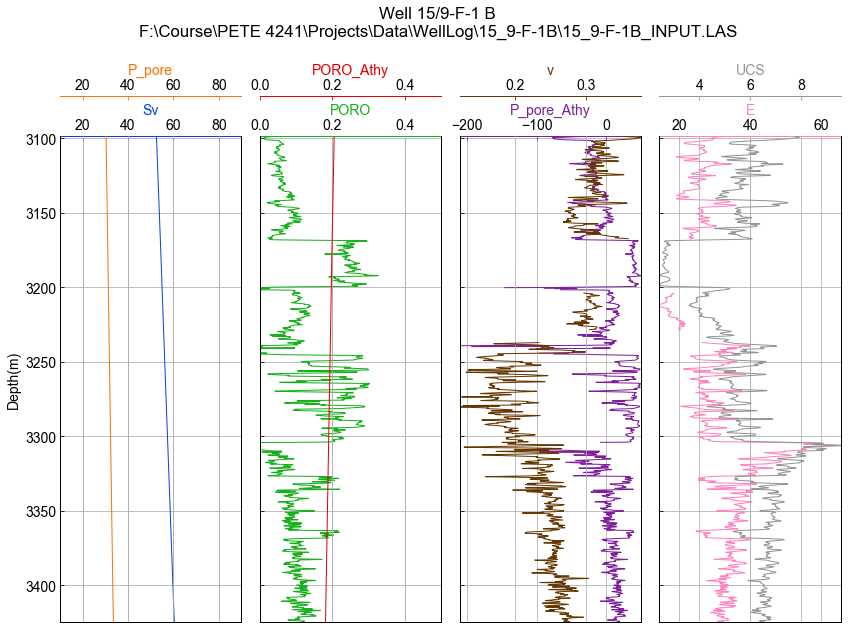

In [15]:
XLims={"P_pore":(10,90),"Sv":(10,90),"PORO_Athy":(0,0.5),"PORO":(0,0.5)}
fig=plm.plotLogs(LogData=l,CurveNames=GeoMechParams.keys(),XLims=XLims)